In [1]:
# Copyright 2022 Huawei Technologies Co., Ltd.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# author: Georg Anegg

In [15]:
filename = '/home/belozes/HyperDAG_DB/tools/HyperDAG_generator/LLtSolver2.txt'
num_entries = 100 # number of (hyperedge_index, node_index) entries to read

In [6]:
from collections import defaultdict 
import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt
import hypernetx as hnx

In [7]:
def read_hdag(filename, num_entries):
    counter = 0
    data = defaultdict(list)
    with open(filename, 'r') as file:
        for line in file:
            if counter < num_entries and not line.startswith('%') and len(line.split()) == 2:
                counter += 1
                net_id, node_id = line.strip().split()
                data[net_id].append(node_id)
    if min(len(nodes) for nodes in data.values()) < 2:
        data = {net_id: nodes for net_id, nodes in data.items() if len(nodes)>1}
        print("There are singleton hyperedges which have been removed.")
    return data

In [18]:
hdag = read_hdag(filename, num_entries)
print(hdag)

There are singleton hyperedges which have been removed.
{'0': ['1', '0', '0', '40', '64'], '1': ['1', '4', '24', '45'], '2': ['1', '5', '41', '65'], '3': ['1', '8', '28', '46'], '4': ['1', '0', '9', '29', '50'], '5': ['1', '0', '10', '42', '66'], '6': ['1', '12', '32', '47'], '8': ['1', '0'], '9': ['1', '0'], '10': ['1', '0'], '12': ['1', '0'], '13': ['1', '0'], '14': ['1', '0'], '15': ['1', '0'], '16': ['1', '0'], '17': ['1', '0'], '18': ['1', '0'], '19': ['1', '0'], '24': ['1', '1'], '28': ['1', '1'], '29': ['1', '1'], '32': ['1', '1'], '33': ['1', '1'], '34': ['1', '1'], '37': ['1', '1'], '38': ['1', '2']}


---
# Show DAG

In [17]:
G = nx.DiGraph()
G.add_edges_from([(net[0], net[i]) for net in hdag.values() for i in range(1,len(net))])
print(G)

DiGraph with 23 nodes and 23 edges


In [13]:
pos = nx.nx_agraph.graphviz_layout(G, prog='dot') # this will also be used for hypergraphs later

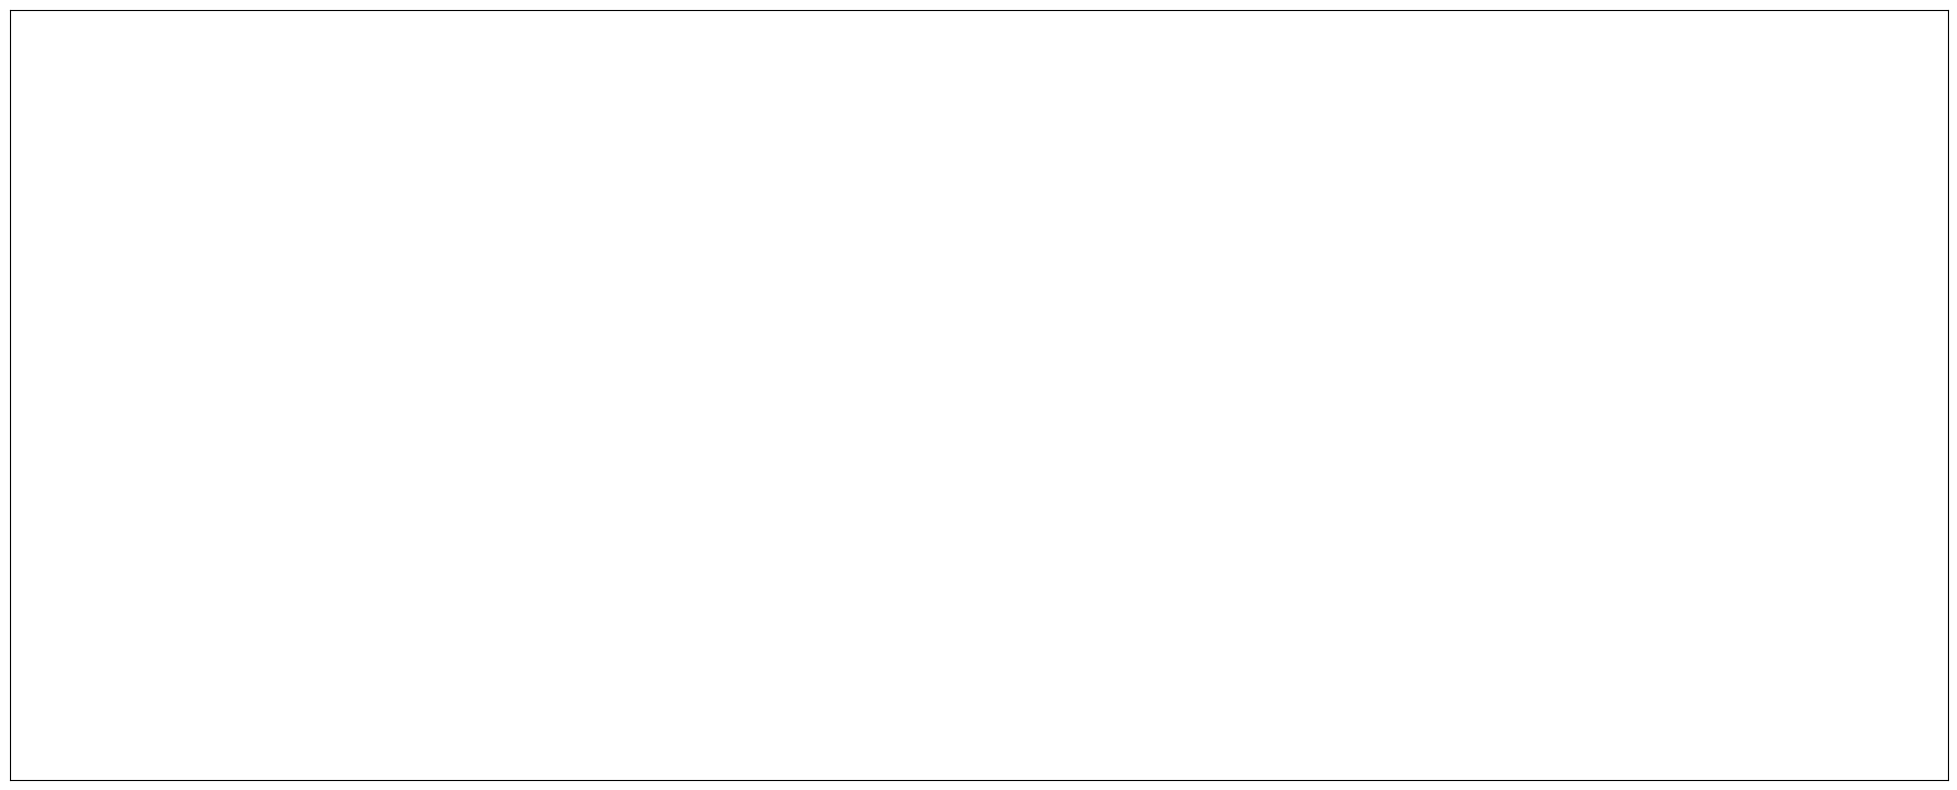

In [14]:
fig = plt.figure()
fig.set_size_inches(25, 10)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=750)
nx.draw_networkx_edges(G, pos, edge_color='blue', arrowsize=30)
nx.draw_networkx_labels(G, pos, font_size=20)
plt.savefig("dag.jpg")
plt.show()

---
# Show HyperDAG (source nodes colored)

In [ ]:
nets = {int(index): tuple(net) for index, net in hdag.items()}
H = hnx.Hypergraph(nets)
sources = {next(iter(net.elements.items()))[0]: net.uid  for net in H.edges()}
# write new attribute source_of to nodes
for v in H.nodes():
    v.source_of = sources.get(v.uid)

In [ ]:
settings = {
    'width': 25,
    'height': 10,
    'xstretch': 1,
    'ystretch': 4,
    'net_padding': 0.2,
    'source_size': 0.8,
    'sink_size': 0.5,
}    

In [ ]:
cmap = plt.cm.viridis
colors = cmap(plt.Normalize(0, len(hdag))(range(len(hdag))))

fig = plt.figure()
fig.set_size_inches(settings['width'], settings['height'])

hnx.drawing.draw(H,
                 pos={key: (settings['xstretch']*x, settings['ystretch']*y) for key, (x,y) in pos.items()}, # use pos from digraph (cannot use graphviz.dot on hypergraphs)
                 edges_kwargs={
                     'edgecolors': colors,
                     'dr': settings['net_padding']
                  },
                 nodes_kwargs={
                    'facecolors': [colors[v.source_of] if v.source_of != None else 'gray' for v in H.nodes()]
                  },
                 node_radius={
                     v.uid: settings['source_size'] if v.uid in sources else settings['sink_size'] for v in H.nodes()
                  }
                )
fig.savefig("hyperdag.jpg")
plt.show()